In [ ]:
import torch
import torch.nn as nn

class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # 1) Dense → 7×7×128 = 6272
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(inplace=True)
        )
        # 3) Upsample → Conv2D+ReLU → BN  (14×14×128)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1     = nn.Conv2d(128, 128, 3, padding=1)
        self.relu1     = nn.ReLU(inplace=True)
        self.bn1       = nn.BatchNorm2d(128, momentum=0.8)
        # 4) Upsample → Conv2D+ReLU → BN  (28×28×64)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2     = nn.Conv2d(128, 64, 3, padding=1)
        self.relu2     = nn.ReLU(inplace=True)
        self.bn2       = nn.BatchNorm2d(64, momentum=0.8)
        # 5) Final Conv2D → tanh  (28×28×3)
        self.conv3     = nn.Conv2d(64, 3, 3, padding=1)
        self.tanh      = nn.Tanh()

    def forward(self, z):
        x = self.fc(z)                            # (B, 6272)
        x = x.view(-1, 128, 7, 7)                 # (B,128,7,7)
        x = self.upsample1(x)                     # (B,128,14,14)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.upsample2(x)                     # (B,128,28,28)
        x = self.relu2(self.bn2(self.conv2(x)))
        return self.tanh(self.conv3(x))           # (B,3,28,28)

class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) Conv2D+LeakyReLU+Dropout → 14×14×32
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # 2) Conv2D (stride=2) → 7×7×64 → ZeroPad → 8×8×64 → BN → LeakyReLU → Dropout
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2   = nn.BatchNorm2d(64, momentum=0.8)
        # 3) Conv2D (stride=2) → 4×4×64 → BN → LeakyReLU → Dropout
        self.conv3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.bn3   = nn.BatchNorm2d(64, momentum=0.8)
        # 4) Conv2D (stride=1) → 4×4×128 → BN → LeakyReLU → Dropout
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(128, momentum=0.8)

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.drop  = nn.Dropout2d(0.25)
        # 5) Flatten → Dense+Sigmoid
        self.flatten = nn.Flatten()
        self.fc      = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.drop(self.lrelu(self.conv1(img)))                  # 14×14×32
        x = self.drop(self.lrelu(self.bn2(self.conv2(x))))# 8×8×64
        x = self.drop(self.lrelu(self.bn3(self.conv3(x))))          # 4×4×64
        x = self.drop(self.lrelu(self.bn4(self.conv4(x))))          # 4×4×128
        x = self.flatten(x)                                         # 2048
        return self.fc(x)                                           # (B,1)


cuda
Starting Training…
Epoch 1/1000  D_loss: 1.6989, G_loss: 0.6229
Epoch 2/1000  D_loss: 1.5060, G_loss: 0.6761
Epoch 3/1000  D_loss: 1.4795, G_loss: 0.6842
Epoch 4/1000  D_loss: 1.4601, G_loss: 0.6825
Epoch 5/1000  D_loss: 1.4503, G_loss: 0.6893
Epoch 6/1000  D_loss: 1.4407, G_loss: 0.6950
Epoch 7/1000  D_loss: 1.4353, G_loss: 0.6948
Epoch 8/1000  D_loss: 1.4239, G_loss: 0.7070
Epoch 9/1000  D_loss: 1.4343, G_loss: 0.6943
Epoch 10/1000  D_loss: 1.4207, G_loss: 0.6996
Epoch 11/1000  D_loss: 1.4231, G_loss: 0.6919
Epoch 12/1000  D_loss: 1.4128, G_loss: 0.6889
Epoch 13/1000  D_loss: 1.4125, G_loss: 0.6995
Epoch 14/1000  D_loss: 1.4126, G_loss: 0.6976
Epoch 15/1000  D_loss: 1.4096, G_loss: 0.7031
Epoch 16/1000  D_loss: 1.4123, G_loss: 0.7105
Epoch 17/1000  D_loss: 1.4101, G_loss: 0.6990
Epoch 18/1000  D_loss: 1.4132, G_loss: 0.6955
Epoch 19/1000  D_loss: 1.3990, G_loss: 0.7061
Epoch 20/1000  D_loss: 1.4003, G_loss: 0.7069
Epoch 21/1000  D_loss: 1.4023, G_loss: 0.6992
Epoch 22/1000  D_lo

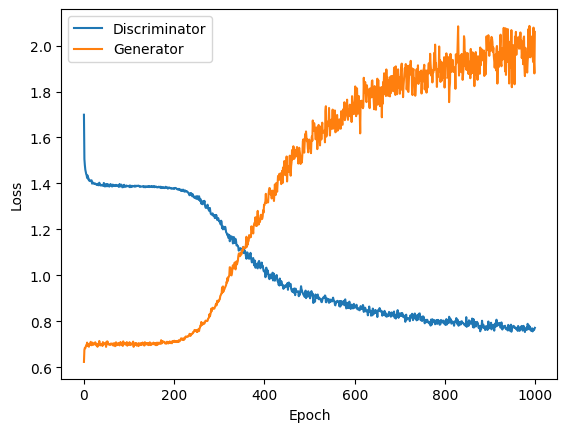

<Figure size 640x480 with 0 Axes>

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

# from capsGAN import CapsGANDiscriminator,CapsGANGenerator,margin_loss
# from GAN import GANGenerator,GANDiscriminator
# from DCGAN import DCGANGenerator, DCGANDiscriminator

warnings.filterwarnings("ignore", "Truncated File Read", UserWarning)


class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy,image_root,subject, transform):
        # load 128-D latents and N filenames
        self.latents  = np.load(latents_npy)          # (N,128)
        self.filenames = np.load(filenames_npy,allow_pickle=True)       # (N,), dtype=str
        self.labels = np.load(labels_npy)
        self.image_root = image_root                  # folder where images live
        self.transform  = transform
        self.sub        = subject

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        # get latent vector
        z = torch.from_numpy(self.latents[idx]).float()
        # load the RGB stimulus image
        path = os.path.join(self.image_root, self.labels[idx], self.filenames[idx])
        img  = Image.open(path).convert("RGB")         # 3 channels
        img  = self.transform(img)                    # → Tensor 3×28×28
        return z, img

def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image


# 28×28 RGB, normalized to [-1,1]
img_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

g = "fine3"

train_ds = LatentImageDataset(
    latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_latents.npy",
    filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_filenames.npy",
    labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_stringLabels.npy",
    image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
    subject  = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_subject.npy",
    transform     = img_transform,
)
train_dataloader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True, drop_last=True)

val_latents   = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_latents.npy")       # (N_val, 128)
val_labels    = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_stringLabels.npy")  # (N_val,), dtype=str
val_filenames = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_filenames.npy",allow_pickle=True)  # (N_val,)
val_subject   = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_subject.npy")

test_ds = LatentImageDataset(
    latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_latents.npy",
    filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_filenames.npy",
    labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_stringLabels.npy",
    image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
    subject       = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_subject.npy",
    transform     = img_transform,
)
test_dataloader = DataLoader(test_ds, batch_size=256, shuffle=True,num_workers=4, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Create discriminator and generator
discriminator = DCGANDiscriminator().to(device)
generator = DCGANGenerator(latent_dim=128).to(device)

# Training in action
num_epochs = 1000

# optimisers and loss
lr = 2e-4

# create optimisers
optimiserG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimiserD = optim.Adam(discriminator.parameters(), lr=lr/2, betas=(0.5, 0.999))

D_loss_history = []
G_loss_history = []

# ckpt = torch.load(f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/DCGAN/DCGANcheckpoint/DCGANcheckpoint_e880.pth")
# generator.load_state_dict(ckpt["model"])
# discriminator.load_state_dict(ckpt["disc"])
# epoch_start     = ckpt['epoch'] + 1
# optimiserG.load_state_dict(ckpt['optG'])
# optimiserD.load_state_dict(ckpt['optD'])
# D_loss_history, G_loss_history = ckpt['losses']


# Create folder to hold result
result_folder = f'/content/drive/MyDrive/ImageNet_Images/GANs - {g}/DCGAN/DCGAN-result'
if not os.path.exists(result_folder ):
    os.makedirs(result_folder )

save_path    = f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/DCGAN/DCGANcheckpoint"
if not os.path.exists(save_path):
    os.makedirs(save_path)

with open(os.path.join(f'/content/drive/MyDrive/ImageNet_Images/GANs - {g}/capsGAN28/capsGAN-result', "fixed_val_filenames.txt")) as f:
    fixed_filenames = [ln.strip() for ln in f if ln.strip()]

fname_to_idx = {fn: i for i, fn in enumerate(val_filenames)}
fixed_idxs   = [fname_to_idx[fn] for fn in fixed_filenames]

fixed_latents = torch.from_numpy(val_latents[fixed_idxs]).float().to(device)

# before training loop

criterion = nn.BCELoss()

print("Starting Training…")
for epoch in range(1, num_epochs+1):
    D_loss_epoch, G_loss_epoch = 0., 0.
    discriminator.train()
    generator.train()
    for latents, real_imgs in train_dataloader:

        latents   = latents.to(device)
        real_imgs = real_imgs.to(device)
        B = real_imgs.size(0)

        # True and False Labels.  128 is the batch size
        true_label = torch.empty(B,1,device=device).uniform_(0.8,1.0)
        false_label = torch.empty(B,1,device=device).uniform_(0.0,0.2)

        # ——— Discriminator step ———
        d_real = discriminator(real_imgs)
        loss_real = criterion(d_real, true_label)
        fake_imgs = generator(latents).detach()
        d_fake = discriminator(fake_imgs)
        loss_fake = criterion(d_fake, false_label)
        lossD     = loss_real + loss_fake

        discriminator.zero_grad()
        lossD.backward()
        optimiserD.step()
        D_loss_epoch += lossD.item()

        # ——— Generator step ———
        fake_imgs = generator(latents)
        d_out = discriminator(fake_imgs)
        lossG     = criterion(d_out, true_label)

        generator.zero_grad()
        lossG.backward()
        optimiserG.step()
        G_loss_epoch += lossG.item()


    # compute averages
    avg_D = D_loss_epoch / len(train_dataloader)
    avg_G = G_loss_epoch / len(train_dataloader)

    # append to history for plotting later
    D_loss_history.append(avg_D)
    G_loss_history.append(avg_G)

    print(f"Epoch {epoch}/{num_epochs}  "
          f"D_loss: {avg_D:.4f}, G_loss: {avg_G:.4f}")

    if epoch % 5 == 0:
        with torch.no_grad():
            generator.eval()
            fake = generator(fixed_latents)  # (80,3,28,28)
            grid = torchvision.utils.make_grid(
                fake,
                nrow=10,
                normalize=True,
                value_range=(-1,1)
            )

            # after built `grid` (a tensor C×H×W):
            np_grid = grid.cpu().permute(1,2,0).numpy()  # H×W×C in [0,1]

            fig, ax = plt.subplots(figsize=(6,6))
            ax.imshow(np_grid)
            ax.axis("off")
            ax.set_title(
                f"Epoch {epoch}/{num_epochs}\n"
                f"D_loss: {avg_D:.4f}, G_loss: {avg_G:.4f}",
                fontsize=12,
                color="white",
                backgroundcolor="black",
                pad=10
            )
            plt.tight_layout()
            plt.savefig(os.path.join(result_folder, f"epoch{epoch:03d}_valgrid.png"))
            plt.close(fig)
            generator.train()
    if epoch % 25 == 0 or avg_G < min(G_loss_history):
        # at save time (e.g. after epoch N):
        torch.save({
            "epoch":   epoch,
            "model":   generator.state_dict(),
            "disc":    discriminator.state_dict(),
            "optG":    optimiserG.state_dict(),
            "optD":    optimiserD.state_dict(),
            "losses":  (D_loss_history, G_loss_history),
        }, os.path.join(save_path,f"DCGANcheckpoint_e{epoch:03d}.pth"))
        print(f"✓ checkpoint saved at epoch {epoch}")


plt.clf()
plt.plot(D_loss_history, label="Discriminator")
plt.plot(G_loss_history, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(result_folder, "Network_Loss_History.png"))

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image


# 28×28 RGB, normalized to [-1,1]
img_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy,
                 image_root, subject, transform):
        self.latents   = np.load(latents_npy)         # (N,128)
        self.filenames = np.load(filenames_npy,allow_pickle=True)  # (N,)
        self.labels    = np.load(labels_npy)          # (N,)
        self.sub       = np.load(subject, allow_pickle=True)  # <— load it here
        self.image_root= image_root
        self.transform = transform

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        z      = torch.from_numpy(self.latents[idx]).float()
        fname  = self.filenames[idx]
        wnid   = self.labels[idx]
        subj   = self.sub[idx]
        path   = os.path.join(self.image_root, wnid, fname)
        img    = Image.open(path).convert("RGB")
        img    = self.transform(img)
        return z, img, fname, wnid, subj


for g in ["fine2","coarse",]:
    test_ds = LatentImageDataset(
        latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_latents.npy",
        filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_filenames.npy",
        labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_stringLabels.npy",
        image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
        subject       = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_subject.npy",
        transform     = img_transform,
    )
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    generator = DCGANGenerator(latent_dim=128).to(device)

    # 2) Load only the generator’s weights from checkpoint:
    ckpt = torch.load(f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/DCGAN/DCGANcheckpoint/DCGANcheckpoint_e1000.pth", map_location=device)
    generator.load_state_dict(ckpt["model"])

    # Create folder to hold result
    result_folder = f'/content/drive/MyDrive/ImageNet_Images/testResults/Time/{g}'
    if not os.path.exists(result_folder ):
        os.makedirs(result_folder )



    # After loading checkpoint & before/after training, do test‐time pass
    generator.eval()
    recon_folder = os.path.join(result_folder, f"DCGAN_reconstructions")
    if not os.path.exists(recon_folder ):
        os.makedirs(recon_folder)

    with torch.no_grad():
        for latents, _, fnames, wnids,sub in test_loader:
            latents = latents.to(device)
            fakes   = generator(latents).cpu()          # (B,3,32,32)

            for i in range(fakes.size(0)):
                # convert tensor → numpy image
                img_np   = im_convert(fakes[i])

                base_name, _ = os.path.splitext(fnames[i])  # → ("n02510455_4381", ".JPEG")
                wnid         = wnids[i]                     # e.g. "n02510455"
                subject   = sub[i]

                out_dir = os.path.join(recon_folder, wnid)
                os.makedirs(out_dir, exist_ok=True)

                save_path = os.path.join(out_dir, f"{base_name}_{subject}.png")
                # PIL expects uint8 in [0,255]
                pil_img = Image.fromarray((img_np*255).astype(np.uint8))
                pil_img = pil_img.resize((64,64), Image.BICUBIC)
                pil_img.save(save_path)

    print(f"Saved all reconstructions to {recon_folder!r}")


cuda
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/fine2/DCGAN_reconstructions'
cuda
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/coarse/DCGAN_reconstructions'


In [ ]:
!pip install git+https://github.com/richzhang/PerceptualSimilarity
!pip install pytorch-fid

  Cloning https://github.com/richzhang/PerceptualSimilarity to /tmp/pip-req-build-5yzqpcm8
  Running command git clone --filter=blob:none --quiet https://github.com/richzhang/PerceptualSimilarity /tmp/pip-req-build-5yzqpcm8
  Resolved https://github.com/richzhang/PerceptualSimilarity to commit 082bb24f84c091ea94de2867d34c4544f68e0963
  Preparing metadata (setup.py) ... done
  Created wheel for lpips: filename=lpips-0.1.4-py3-none-any.whl size=53704 sha256=addfca225edc44e2d09ab5578198e05a2a3578996af292fade4f5a82494c7ee9
  Stored in directory: /tmp/pip-ephem-wheel-cache-baq6uqa7/wheels/77/cd/3f/37972ad6e9fd7a596fce1195cc5f505bb009f51efc3504e67d
Successfully built lpips


Device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
[fine2] Found 40 checkpoints in /content/drive/MyDrive/ImageNet_Images/GANs - fine2/DCGAN/DCGANcheckpoint: [25, 50, 75, 100, 125, 150, 175, 200] ...
[fine2] epoch   25 | LPIPS 0.8153 ± 0.0041 | CFID 455.45 ± 25.71
[fine2] epoch   50 | LPIPS 0.7520 ± 0.0030 | CFID 425.44 ± 19.31
[fine2] epoch   75 | LPIPS 0.7373 ± 0.0032 | CFID 391.94 ± 14.09
[fine2] epoch  100 | LPIPS 0.7419 ± 0.0019 | CFID 409.84 ± 14.51
[fine2] epoch  125 | LPIPS 0.7568 ± 0.0035 | CFID 423.97 ± 16.37
[fine2] epoch  150 | LPIPS 0.7469 ± 0.0030 | CFID 418.00 ± 16.35
[fine2] epoch  175 | LPIPS 0.7340 ± 0.0033 | CFID 395.15 ± 13.77
[fine2] epoch  200 | LPIPS 0.7371 ± 0.0028 | CFID 411.93 ± 12.82
[fine2] epoch  225 | LPIPS 0.7534 ± 0.0023 | CFID 418.32 ± 10.69
[fine2] epoch  250 | LPIPS 0.7385 ± 0.0053 | CFID 432.92 ± 16.93
[fine2] epoch  275 | LPIPS 0.7

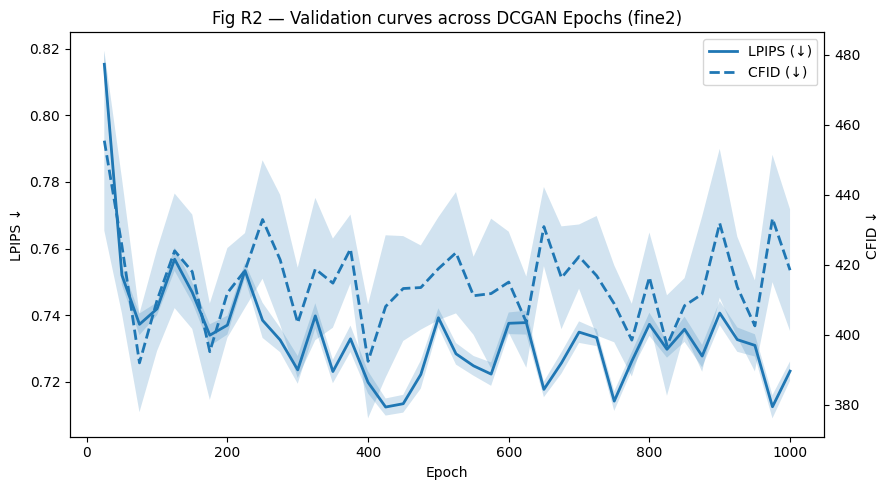

[fine3] Found 40 checkpoints in /content/drive/MyDrive/ImageNet_Images/GANs - fine3/DCGAN/DCGANcheckpoint: [25, 50, 75, 100, 125, 150, 175, 200] ...
[fine3] epoch   25 | LPIPS 0.7913 ± 0.0013 | CFID 426.91 ± 13.00
[fine3] epoch   50 | LPIPS 0.7910 ± 0.0015 | CFID 456.96 ± 21.04
[fine3] epoch   75 | LPIPS 0.7796 ± 0.0013 | CFID 398.76 ± 23.57
[fine3] epoch  100 | LPIPS 0.7633 ± 0.0017 | CFID 419.80 ± 13.17
[fine3] epoch  125 | LPIPS 0.7698 ± 0.0015 | CFID 421.29 ± 13.53
[fine3] epoch  150 | LPIPS 0.7614 ± 0.0014 | CFID 390.97 ± 15.97
[fine3] epoch  175 | LPIPS 0.7559 ± 0.0020 | CFID 381.84 ± 14.87
[fine3] epoch  200 | LPIPS 0.7640 ± 0.0014 | CFID 391.77 ± 13.35
[fine3] epoch  225 | LPIPS 0.7565 ± 0.0017 | CFID 405.09 ± 9.12
[fine3] epoch  250 | LPIPS 0.7537 ± 0.0015 | CFID 389.45 ± 9.92
[fine3] epoch  275 | LPIPS 0.7526 ± 0.0015 | CFID 398.80 ± 12.99
[fine3] epoch  300 | LPIPS 0.7565 ± 0.0017 | CFID 399.26 ± 12.38
[fine3] epoch  325 | LPIPS 0.7493 ± 0.0016 | CFID 393.25 ± 16.67
[fine3] 

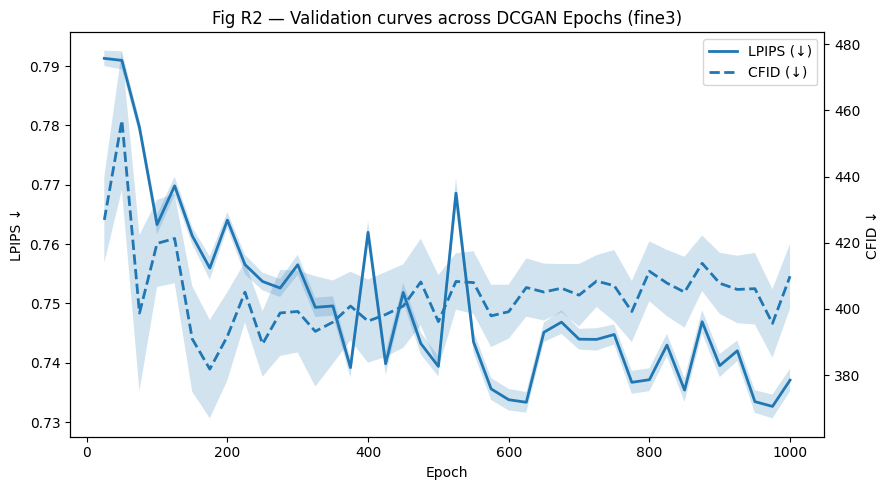

Done. Figures saved in each granularity folder under 'DCGAN Metric Curves/'.


In [ ]:
# ===========================================
# Fig R2 — LPIPS↓ & Inception-based CFID↓ vs Epoch (FAST)
# - Strict checkpoint discovery in .../cProGAN/cProGAN_checkpoint (e###)
# - AMP for Generator + Inception (LPIPS stays fp32)
# - LPIPS upsample to 96×96 to avoid pooling crash
# - CFID uses per-class stats + class-bootstrap (cheap)
# - Vertical dashed lines = grow_schedule stage transitions
# ===========================================

import os, re, random, warnings
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Metrics / feature extractors
import lpips
from pytorch_fid.inception import InceptionV3
from scipy import linalg

warnings.filterwarnings("ignore")

# -----------------------------
# Reproducibility (seed, but allow fast kernels)
# -----------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # faster; turn off if strict determinism is required

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Data transform (model expects [-1,1])
# -----------------------------
img_transform = T.Compose([
    T.Resize(28),
    T.CenterCrop(28),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

# -----------------------------
# Dataset (latents + real images + labels)
# -----------------------------
class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy,
                 image_root, subject, transform):
        self.latents    = np.load(latents_npy)
        self.filenames  = np.load(filenames_npy, allow_pickle=True)
        self.labels_str = np.load(labels_npy)
        self.image_root = image_root
        self.transform  = transform
        self.sub        = np.load(subject, allow_pickle=True)

        classes = np.unique(self.labels_str)
        self.cls2idx = {c:i for i,c in enumerate(classes)}
        self.labels_int = np.array([self.cls2idx[c] for c in self.labels_str],
                                   dtype=np.int64)

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        z     = torch.from_numpy(self.latents[idx]).float()
        cls   = self.labels_str[idx]
        fname = self.filenames[idx]
        path  = os.path.join(self.image_root, cls, fname)
        img   = Image.open(path).convert("RGB")
        img   = self.transform(img)
        subj  = self.sub[idx]
        y_int = int(self.labels_int[idx])
        return z, img, fname, cls, y_int, subj

# -----------------------------
# LPIPS (VGG backbone) + safe upsample
# -----------------------------
LPIPS_SIZE = 96  # >=64 to survive VGG pooling
lpips_model = lpips.LPIPS(net="vgg").to(device).eval()

@torch.no_grad()
def lpips_distance(x_fake: torch.Tensor, x_real: torch.Tensor) -> torch.Tensor:
    """
    Inputs: [-1,1], [B,3,H,W] (H=W=28). We upsample to LPIPS_SIZE before LPIPS.
    Returns: [B] LPIPS on CPU.
    """
    xf = F.interpolate(x_fake, size=(LPIPS_SIZE, LPIPS_SIZE), mode="bilinear", align_corners=False)
    xr = F.interpolate(x_real, size=(LPIPS_SIZE, LPIPS_SIZE), mode="bilinear", align_corners=False)
    d = lpips_model(xf, xr)
    return d.view(-1).detach().cpu()

# -----------------------------
# Inception features for CFID (2048-D, pool3)
# -----------------------------
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception = InceptionV3([block_idx]).to(device).eval()

@torch.no_grad()
def get_inception_feats(x: torch.Tensor) -> torch.Tensor:
    """
    x: [-1,1], [B,3,H,W] -> [B,2048] features on CPU (float32)
    Uses AMP on CUDA for speed.
    """
    use_amp = (device.type == "cuda")
    with torch.autocast(device_type=device.type, enabled=use_amp):
        xx = F.interpolate(x, size=(299,299), mode="bilinear", align_corners=False)
        xx = (xx * 0.5 + 0.5).clamp(0,1)  # to [0,1]
        feats = inception(xx)[0].squeeze(-1).squeeze(-1)
    return feats.float().cpu()

# -----------------------------
# Frechet distance
# -----------------------------
def frechet_distance(mu1: torch.Tensor,
                     sigma1: torch.Tensor,
                     mu2: torch.Tensor,
                     sigma2: torch.Tensor,
                     eps: float = 1e-6) -> float:
    mu1 = mu1.double().cpu().numpy()
    mu2 = mu2.double().cpu().numpy()
    sigma1 = sigma1.double().cpu().numpy()
    sigma2 = sigma2.double().cpu().numpy()

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fd = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2.0 * tr_covmean
    return float(fd)

# -----------------------------
# FAST CFID: per-class stats + class bootstrap
# -----------------------------
def per_class_stats(feats: torch.Tensor, labels: List[str], min_n: int = 10
                   ) -> Dict[str, Tuple[torch.Tensor, torch.Tensor, int]]:
    """
    Return {class: (mu[D], Sigma[D,D], n)} on CPU tensors.
    """
    labels_np = np.array(labels)
    stats = {}
    for cls in np.unique(labels_np):
        idx = np.where(labels_np == cls)[0]
        if len(idx) < min_n:
            continue
        f = feats[idx]                      # [n,D] CPU float32
        mu = f.mean(0)
        d = f.shape[1]
        I = torch.eye(d)                    # CPU
        Sigma = torch.cov(f.T).float() + 1e-6 * I
        stats[cls] = (mu, Sigma, len(idx))
    return stats

def cfid_from_stats(real_stats: Dict[str, Tuple[torch.Tensor, torch.Tensor, int]],
                    fake_stats: Dict[str, Tuple[torch.Tensor, torch.Tensor, int]]
                   ) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Compute CFID using precomputed per-class (mu,Sigma,n).
    Returns:
      cfid_point: weighted average over classes
      class_dists: array[K]
      class_weights: array[K] (counts)
    """
    dists, weights = [], []
    for cls in set(real_stats.keys()).intersection(fake_stats.keys()):
        mu_r, S_r, n = real_stats[cls]
        mu_f, S_f, _ = fake_stats[cls]
        d_cf = frechet_distance(mu_r, S_r, mu_f, S_f)
        dists.append(d_cf)
        weights.append(n)
    if not dists:
        return float("nan"), np.array([]), np.array([])
    dists = np.array(dists, float)
    weights = np.array(weights, int)
    wnorm = weights / weights.sum()
    cfid_point = float(np.average(dists, weights=wnorm))
    return cfid_point, dists, weights

def class_bootstrap_mean_std_cfid(class_dists: np.ndarray,
                                  class_weights: np.ndarray,
                                  B: int,
                                  rng: np.random.Generator) -> Tuple[float, float]:
    """
    Bootstrap CFID by resampling classes (with replacement), weighting by sampled weights.
    """
    K = len(class_dists)
    if K == 0:
        return float("nan"), float("nan")
    vals = np.empty(B, dtype=np.float64)
    for b in range(B):
        idx = rng.integers(0, K, size=K, endpoint=False)
        vals[b] = np.average(class_dists[idx], weights=class_weights[idx])
    return float(vals.mean()), float(vals.std(ddof=1))

# -----------------------------
# Stage transition epochs from grow_schedule
# -----------------------------
def find_stage_transitions(grow_fn, max_epoch: int):
    transitions = []
    prev_step = None
    for e in range(1, max_epoch+1):
        step, alpha = grow_fn(e-1)
        if prev_step is None:
            prev_step = step
        elif step != prev_step:
            transitions.append(e)
            prev_step = step
    return transitions

# -----------------------------
# Strict checkpoint discovery (non-recursive, e### only)
# -----------------------------
CKPT_RE = re.compile(r'DCGANcheckpoint_e(\d{3,})\.pth$', re.IGNORECASE)

def discover_checkpoints_exact(dir_path: str) -> Dict[int, str]:
    """
    Scan ONLY dir_path for files like: cProGAN*checkpoint_e###.pth
    Returns {epoch:int -> path:str}, sorted by epoch.
    """
    found: Dict[int, str] = {}
    if not os.path.isdir(dir_path):
        return found
    for fname in os.listdir(dir_path):
        m = CKPT_RE.match(fname)
        if not m:
            continue
        ep = int(m.group(1))
        found[ep] = os.path.join(dir_path, fname)
    return dict(sorted(found.items(), key=lambda kv: kv[0]))

def bootstrap_mean_and_std_lpips(lpips_values: np.ndarray, B: int, rng: np.random.Generator):
    """Bootstrap the mean LPIPS over samples; returns (mean, std)."""
    N = lpips_values.shape[0]
    if N == 0:
        return float("nan"), float("nan")
    means = np.empty(B, dtype=np.float64)
    for b in range(B):
        idx = rng.integers(0, N, size=N, endpoint=False)
        means[b] = lpips_values[idx].mean()
    return float(means.mean()), float(means.std(ddof=1))

def lpips_mean_std(lpips_vals: np.ndarray, bootstrap: bool, B: int, rng: np.random.Generator):
    """Return (mean, std) for LPIPS; uses bootstrap when requested & sample size is decent."""
    if bootstrap and lpips_vals.size >= 50:
        return bootstrap_mean_and_std_lpips(lpips_vals, B, rng)
    return float(lpips_vals.mean()), float(lpips_vals.std(ddof=1))

HAS_GROW = 'grow_schedule' in globals()

# -----------------------------
# Main evaluation & plotting
# -----------------------------
granularities = ["fine2", "fine3"]  # adjust as needed
BATCH_SIZE = 256
NUM_WORKERS = 4
BOOTSTRAP_SAMPLES = 100  # 50–100 is usually plenty with class-bootstrap

for g in granularities:
    # --- dataset / loader (VAL set) ---
    base = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}"
    test_ds = LatentImageDataset(
        latents_npy   = f"{base}/val_latents.npy",
        filenames_npy = f"{base}/val_filenames.npy",
        labels_npy    = f"{base}/val_stringLabels.npy",
        image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
        subject       = f"{base}/val_subject.npy",
        transform     = img_transform,
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    # --- classes per granularity (adjust if different) ---
    if g in ("coarse",):
        n_classes = 40
    else:
        n_classes = 8

    generator = DCGANGenerator(latent_dim=128).to(device)

    result_folder = f'/content/drive/MyDrive/ImageNet_Images/testResults/DCGAN Metric Curves/{g}'
    os.makedirs(result_folder, exist_ok=True)

    # -------- discover checkpoints (STRICT dir & pattern) --------
    ckpt_dir  = f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/DCGAN/DCGANcheckpoint"
    ckpts = discover_checkpoints_exact(ckpt_dir)
    if not ckpts:
        print(f"[{g}] No checkpoints found under: {ckpt_dir}")
        continue
    epochs_available = list(ckpts.keys())
    print(f"[{g}] Found {len(epochs_available)} checkpoints in {ckpt_dir}: {epochs_available[:8]}{' ...' if len(epochs_available)>8 else ''}")

    # -------- stage lines from grow schedule --------
    if HAS_GROW:
        grow_fn = grow_schedule(max_res=28, ep=40)
        stage_lines = find_stage_transitions(grow_fn, max_epoch=max(epochs_available))
    else:
        grow_fn = None
        stage_lines = []

    # -------- precompute REAL features & labels once --------
    all_real_feats = []
    all_labels = []
    with torch.no_grad():
        for _, real_imgs, _, wnids, _, _ in test_loader:
            real_imgs = real_imgs.to(device, non_blocking=True)
            rf = get_inception_feats(real_imgs)   # CPU [B,2048]
            all_real_feats.append(rf)
            all_labels.extend(list(wnids))
    all_real_feats = torch.cat(all_real_feats, dim=0)   # [N,2048] CPU
    real_stats = per_class_stats(all_real_feats, all_labels)  # dict per class
    del all_real_feats  # free RAM

    # --- storage for curves ---
    epochs = []
    lpips_mu, lpips_std = [], []
    cfid_mu,  cfid_std  = [], []

    rng = np.random.default_rng(SEED)
    USE_AMP = (device.type == "cuda")

    for ep, ckpt_path in ckpts.items():
        # Load generator
        ckpt = torch.load(ckpt_path, map_location=device)
        generator.load_state_dict(ckpt["model"])
        generator.eval()

        if HAS_GROW:
            step, alpha = grow_fn(ep-1)
        else:
            step = alpha = 0  # unused

        # Accumulate per-sample metrics & FAKE features (real stats cached)
        all_lpips = []
        all_fake_feats = []

        with torch.no_grad():
            for latents, real_imgs, _, _, y_int, _ in test_loader:
                latents   = latents.to(device, non_blocking=True)
                y         = y_int.to(device, non_blocking=True)
                real_imgs = real_imgs.to(device, non_blocking=True)

                # faster forward with AMP
                with torch.autocast(device_type=device.type, enabled=USE_AMP):
                    if HAS_GROW:
                        fakes = generator(latents, y, step, alpha)
                    else:
                        # typical ACGAN forward(z, y)
                        fakes = generator(latents)

                # LPIPS in fp32 on upsampled images
                all_lpips.append(lpips_distance(fakes, real_imgs))

                # Inception feats of fakes (AMP inside)
                ff = get_inception_feats(fakes)   # CPU float32
                all_fake_feats.append(ff)

        lpips_vals = torch.cat(all_lpips, dim=0).numpy()  # [N]
        fake_feats = torch.cat(all_fake_feats, dim=0)     # [N,2048] CPU

        # ---- CFID via per-class stats (single sqrtm per class) ----
        fake_stats = per_class_stats(fake_feats, all_labels)
        cf_point, class_dists, class_weights = cfid_from_stats(real_stats, fake_stats)

        # ---- Bootstrap: LPIPS over samples; CFID over classes ----
        # ---- Bootstrap: LPIPS over samples; CFID over classes ----
        lp_mu, lp_sd = lpips_mean_std(lpips_vals, bootstrap=True, B=BOOTSTRAP_SAMPLES, rng=rng)
        cf_mu, cf_sd = class_bootstrap_mean_std_cfid(class_dists, class_weights,
                                             BOOTSTRAP_SAMPLES, rng)


        epochs.append(ep)
        lpips_mu.append(lp_mu)
        lpips_std.append(lp_sd)
        cfid_mu.append(cf_mu)
        cfid_std.append(cf_sd)

        if HAS_GROW:
            print(f"[{g}] epoch {ep:4d} | LPIPS {lp_mu:.4f} ± {lp_sd:.4f} | "
                  f"CFID {cf_mu:.2f} ± {cf_sd:.2f} | step {step}, alpha {alpha:.2f}")
        else:
            print(f"[{g}] epoch {ep:4d} | LPIPS {lp_mu:.4f} ± {lp_sd:.4f} | "
                  f"CFID {cf_mu:.2f} ± {cf_sd:.2f}")

        torch.cuda.empty_cache()

    # ------ Plot Fig R2 for this granularity ------
    if len(epochs) == 0:
        print(f"[{g}] No checkpoints plotted.")
        continue

    order = np.argsort(epochs)
    epochs_np = np.array(epochs)[order]
    lp_mu_np  = np.array(lpips_mu)[order]
    lp_sd_np  = np.array(lpips_std)[order]
    cf_mu_np  = np.array(cfid_mu)[order]
    cf_sd_np  = np.array(cfid_std)[order]

    plt.figure(figsize=(9,5))
    ax1 = plt.gca()

    # LPIPS (solid)
    ax1.plot(epochs_np, lp_mu_np, label="LPIPS (↓)", linewidth=2)
    ax1.fill_between(epochs_np, lp_mu_np - lp_sd_np, lp_mu_np + lp_sd_np, alpha=0.2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("LPIPS ↓")

    # CFID (dashed) on twin axis
    ax2 = ax1.twinx()
    ax2.plot(epochs_np, cf_mu_np, linestyle="--", linewidth=2, label="CFID (↓)")
    ax2.fill_between(epochs_np, cf_mu_np - cf_sd_np, cf_mu_np + cf_sd_np, alpha=0.2)
    ax2.set_ylabel("CFID ↓")

    # Stage transitions (vertical dashed lines)
    grow_max = max(epochs_np)
    stage_lines = [e for e in stage_lines if epochs_np.min() <= e <= grow_max]
    for e in stage_lines:
        ax1.axvline(e, linestyle=":", linewidth=1)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.title(f"Fig R2 — Validation curves across DCGAN Epochs ({g})")
    plt.tight_layout()

    out_path = os.path.join(result_folder, f"Fig_R2_{g}.png")
    plt.savefig(out_path, dpi=220)
    plt.show()

print("Done. Figures saved in each granularity folder under 'DCGAN Metric Curves/'.")
